<a href="https://colab.research.google.com/github/agharbi6/dlaicourse/blob/master/Reinforcement_Learning_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What is Reinforcement Learning?  
RL is an area of machine learning in which an agent interacts with its environment and builds experience through trial and error. This interaction can be done by performing an action. This action may or may not change the agent's state and results in either a reward or a penalty. The agent therefore attempts to maximize its rewards by observing the outcome of its actions in various states.

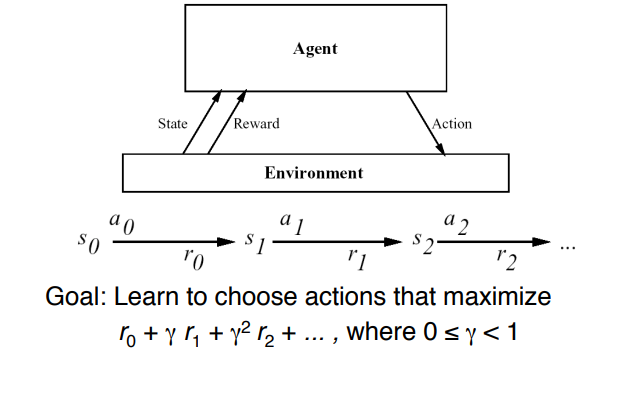

*Image source: CS536 Reinforcement Learning Slides by Wu Littman* 

Applications of reinforcement learning can be found in games, robotics, operations research, multi-agent system, etc. 

Example: Training the best super Mario player [Super Mario](https://www.youtube.com/watch?v=1qa7oRhZvbM)

# Taxonomy of Reinforcement Learning 
There are multiple strategies/algorithms that are used in reinforcement learning. The main two classes are model-based learning and model-free learning algorithms. 

In model-based algorithms, the transitions between states and rewards are approximated by models (functions) that are improved (learned) through experience. This makes the objective of finding the optimal solution more straight forward but it can be very expensive. 

Model-free strategies, as their name sugggests, bypass the modeling part and learn directly the states and policies that achieve optimality in a pure trial/error fashion. They simply collect samples and average over them. This is less expensive computationally but can be more biased. 

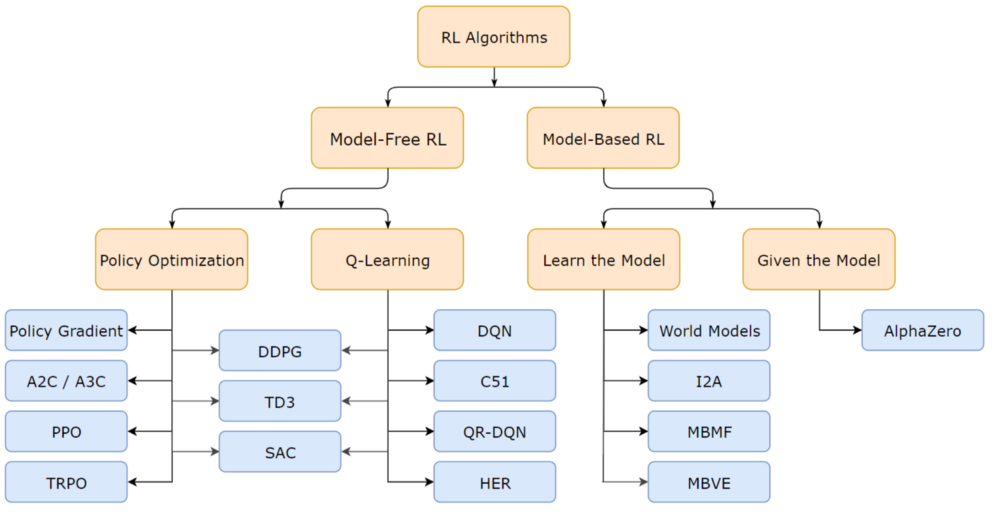

[Image source](https://smartlabai.medium.com/reinforcement-learning-algorithms-an-intuitive-overview-904e2dff5bbc)

# The Taxi Problem

In this tutorial we will explore how a model-free RL algorithm works using the [Taxi problem](https://arxiv.org/abs/cs/9905014) introduced by Ditterich in 1999. 

The Taxi-v3 problem in openai/gym is characterized by a grid of 25 cells. This grid has 4 locations designated by 4 letters: R(red), B(blue), G(green) and Y(yellow). A passenger is located randomly at one of these four locations and wishes to be transported to any one of the four locations. The taxi needs to drive to the passenger location, pick them up, drive them to their destination and drop them off. The taxi is supposed to operate in the environment (grid) without hitting the walls (the passenger wishes to live longer). 

    +---------+
    |R: | : :G|
    | : : : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+

There are 6 actions that the taxi can perform:  

*   0: move south
*   1: move north
*   2: move east
*   3: move west 
*   4: pickup passenger
*   5: drop off passenger

The rewards are defined as follows: 
* Successful dropoff: +20 points
* Illegal pickup/dropoff: -10 points
* Every other action: -1 point

The grid rendering uses the scheme below: 
* blue: passenger
* magenta: destination
* yellow: empty taxi
* green: full taxi

In [ ]:
# Command to install gym, DO NOT CHANGE
import sys
!{sys.executable} -m pip install gym

In [ ]:
# Package imports
import matplotlib
import matplotlib.pyplot as plt
import random

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
# Importing the libraries needed for our problem
import gym
import numpy as np

## Creating the environment
Now we can create our environment by simply running the commands given below.

In [ ]:
# Create the environment 
env = gym.make('Taxi-v3')
env.reset()
env.render() 

## About the gym interface
There are three main operations that you can execute in this environment. We already used two of them

* __env.reset()__ : resets the environment to its initial state. It returns an initial observation
* __env.render()__ : outputs the current state of the environment
* __env.step(action)__ : performs an action and returns 4 values 
 * _observation_ : an object to represent your environment
 * _reward_ : reward gained from performing the last action
 * _done_ : True of false for whether the environment finished its tasks or not. 
 * _info_ : Extra information that you don't have to worry about for now. 
 
For further information about gym, please consider checking their website https://gym.openai.com/
 
The space of observations and actions in gym is already defined. Run the next commands to discover how these spaces look like in this problem. 

In [ ]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

As you can see, there are 500 states and 6 actions in your environment.

Play around with all possible actions (i.e. 0 through 5)

In [ ]:
# TODO: experiment with the six actions in the env.action_space.
# (i.e.  just run each action and then render to show the result)
# Hint: env.step(action_number) performs an action.
#       env.render() shows the current state

state, _, _, _ = env.step(1)
env.render()
print(state)

**What do you see?** 

**Where does 500 come from?**

## Play time
As a first introduction to this problem, try to run the model for a couple of iterations. 

In [ ]:
gains = list()            # to collect total rewards (gains)
rewards = list()          # to collect immediate rewards
iterations = list()       # to collect iterations

state = env.reset()        # resets the environment and returns an initial state
gain, reward = 0, 0     

# TODO - BEGIN: Run a couple of steps and record the iteration number, current reward, and current sum of rewards (gain) defined in the lists above. 

for i in range(1000):
  # choose a random action to take 
  action = random.randint(0, 5) 

  # execute the action 
  # What needs to go here?
  _, reward, _, _ = env.step(action) 

  # collect the reward and add it to the gain 
  #gain = # What needs to go here? 
  gain += reward 
  # record the iteration number, reward and gain every 10 iterations
  if i%10 == 0:
    iterations.append(i)
    rewards.append(reward)
    gains.append(gain)

# TODO - END

Now let's plot the results. The plotting function is already provided for you. 

In [ ]:
def plotRewardsAndGains(iterations, rewards, gains):
    matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
    plt.figure(1)
    
    plt.subplot(121)
    plt.plot(iterations, rewards, 'x')
    plt.xlabel('iterations'); plt.ylabel('rewards')
    
    plt.subplot(122)
    plt.plot(iterations, gains)
    plt.xlabel('iterations'); plt.ylabel('gain')

    plt.show()

In [ ]:
# print the rewards and gains across iterations, any comments?         
plotRewardsAndGains(iterations, rewards, gains)

## Training using Q-Learning

Now we will try to train our model using a better strategy than brute force by using a popular RL algorithm: Q-Learning. 

Q stands for quality. So given a state `s` and an action `a`, `Q*(s,a)` estimates a value that represents how useful the action `a` is in gaining future reward. 

The Q-function uses Bellman equation to estimate the quality value which is stored in a Q-table. 

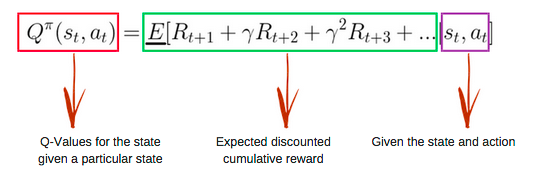

[Image source](https://www.freecodecamp.org/news/an-introduction-to-q-learning-reinforcement-learning-14ac0b4493cc/)

From the Bellman equation, the Q-values are calculated using the expected values of the cumulative weighted reward. Let's try implementing this next. First, some set up is needed

In [ ]:
state = env.reset()
Q = np.zeros([env.observation_space.n, env.action_space.n])

In [ ]:
def compute_q_sample(Q, currState, currAction, newState, reward, lr, discount):
    """
        Input:
            Q          : a SxA matrix, where S is the number of states and A is the number of actions
            currState  : the current state
            currAction : the current action taken
            newState   : the new state resulting from 'currAction' on 'currState'
            reward     : the immediate reward
            lr         : the learning rate
            discount   : the discount factor
            
        Output:
            The sample value for updating Q. 
    """

    val = 0

    #val = reward + discount * np.max(Q[newState, :])

    # Replace the val calculation by the line below, what is the difference between the two calculations of a Q-value?                                   
    val = (1 - lr) * Q[currState,currAction] + lr * (reward + discount * np.max(Q[newState, :])) 

    return val
    

The function above updates one cell in the Q-table. In the Q-learning algorithm, you'll need to "solve" the entire problem in which an episode starts with the taxi driving to pick up the passenger and ends when the passenger is dropped off. "Solve" is loosely defined here to indicate reaching an end state or dropping off the passenger. An optimal solution can be characterized by getting an average reward of 9.6 over 100 consecutive trials. 

The next task is to implement one episode of this problem. The episode has the following steps
* Start from an initial state
* While game not done
 * Greedily select one action 
 * Using this action, go to the next state
 * Compute Q(state, action) 
 * Update the state and total gain

In [ ]:
def RunSingleQLearningEpisode(Q, env, learning_rate=0.6, discount=0.9, epsilon=0):
    """ Run Q-learning on a single episode and update the Q-table

       Input:
            Q     : a SxA matrix, where S is the number of states and A is the number of actions
            env   : the RL environment 
            
        Output:
            [gain, finalState] 
                A tuple containing the total gain (sum of rewards) and the final state reached
    """
    state = env.reset()
    gain = 0
    finalState = None
    done = False 
    
    while not done:

        # select an action 
        action = np.argmax(Q[state, :])

        '''
        To introduce more randomness in this process, we can use the epsilon greedy policy to select the next action. This helps to avoid getting stuck in a local optimum. 
        if random.random() < epsilon:
            action = random.randint(0,5)
        else:
            action = np.argmax(Q[state, :])
        epsilon -= 0.001
        '''  
        # using this action, go to the next state
        nextstate, reward, done, _ = env.step(action)
        
        # compute Q(state,action) 
        Q[state, action] = compute_q_sample(Q, state, action, nextstate, reward, learning_rate, discount)
        
        # update the state and total gain
        state = nextstate
        gain += reward        
    
    finalState = nextstate
    
    return gain, finalState

Now, we're ready to run this episode many times to help the taxi learn the optimal policy. Let's train the algorithm for 10000 iterations and print the total gain every 100 steps. 

In [ ]:
state = env.reset()
counter = 0
reward = None

gains = list()
epochs = list()

Q = np.zeros([env.observation_space.n, env.action_space.n])

for counter in range(10000):
    gain, finalState = RunSingleQLearningEpisode(Q, env)
    if counter % 100 == 0:
        print(gain)
        env.render()
        epochs.append(counter)
        gains.append(gain)  

        

In [ ]:
plt.plot(epochs, gains);
plt.xlabel('epochs');
plt.ylabel('gain')
plt.show()

If implemented correctly, the Q-Learning algorithm converges to the optimal policy. This means that using the Q-table, the best sequence of actions to pick up the passenger and drop them off can be identified. 

Let's find the optimal policy when starting from a random state. 
Print the state, sequence of actions and the final total gain.

In [ ]:

def PlaySingleGame(Q, env):
    """ Run Q-learning on a single episode and update the Q-table

        Input:
            Q     : a SxA matrix, where S is the number of states and A is the number of actions
            env   : the RL environment 
    """
    
    currState = env.reset()
    totalGain = 0;               # total gain accumulated across game
    
    # show initial state
    env.render()

    # TODO: Run a game from start to end. Print the action taken at each step
    done = False
    
    while not done:
        action = np.argmax(Q[currState,:])
        nextState, reward, done, _ = env.step(action)
        currState = nextState
        totalGain += reward
        env.render()
    # show final state
    env.render()    
    print("Total Gain = ", totalGain)
    return totalGain


    

In [ ]:
PlaySingleGame(Q,env)

In [ ]:
# Run the games multiple times to see the average total gain

totalGain = 0
gains = list()
for i in range(100):
    totalGain = PlaySingleGame(Q,env)
    gains.append(totalGain)

print(np.average(gains))

In [ ]:
# Let's run a full factorial DOE on this problem and identify the parameters that yield the highest average total gain 

lrs = [0.4,0.5,0.6,0.7,0.8]
discounts = [0.5,0.6,0.7,0.8,0.9]
epsilons = [0,0.1,0.2,0.3,0.4,0.5]
averages = list()
for i in range(5):
    for j in range(5):
        for k in range(6):
            lr = lrs[i]
            discount = discounts[j]
            epsilon = epsilons[k]
            print("learning rate = ", lr)
            print("discount = ", discount)
            print("epsilon = ", epsilon)
            Q = np.zeros([env.observation_space.n, env.action_space.n])
            for counter in range (10000):
                gain, finalState = RunSingleQLearningEpisode(Q, env, lr, discount, epsilon)
                if counter % 100 == 0:
                    gains.append(gain)
            totalgains = list();
            for l in range(100):
                totalgain = PlaySingleGame(Q,env)
                totalgains.append(totalgain)
            avg = np.average(totalgains)
            print("Average total gain = ", avg)
            averages.append(avg)
print(max(averages))

## Discussion 



*   Which combination of parameters gives the highest gain? 
*   How did the epsilon greedy-policy affect the training? 

# [The Lunar Lander Problem](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py)

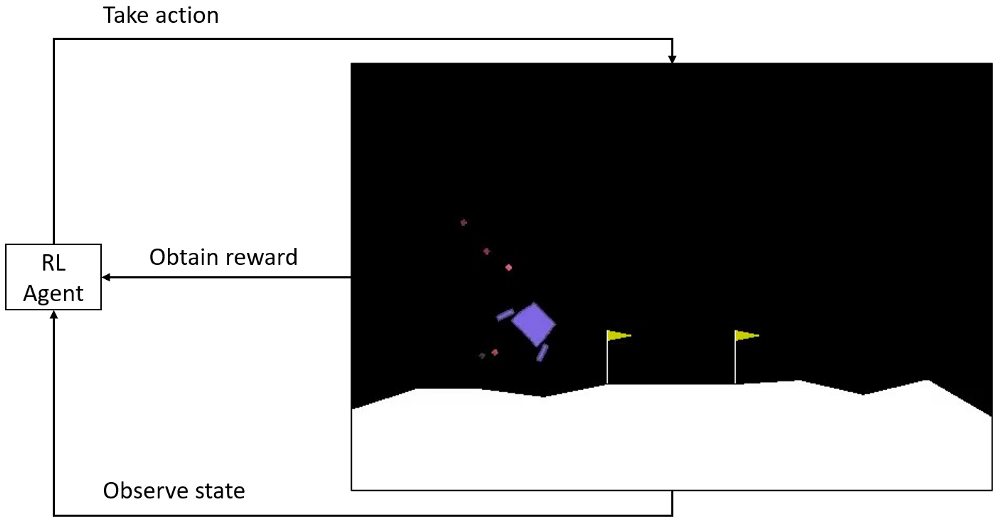

## Description 
This environment is a classic rocket trajectory optimization problem.
According to Pontryagin's maximum principle, it is optimal to fire the
engine at full throttle or turn it off. This is the reason why this
environment has discreet actions: engine on or off.
There are two environment versions: discrete or continuous.
The landing pad is always at coordinates (0,0). The coordinates are the
first two numbers in the state vector.
Landing outside the landing pad is possible. Fuel is infinite, so an agent
can learn to fly and then land on its first attempt.


## Action space
There are four discrete actions available: 
1.   do nothing
2.   fire left orientation engine
3.   fire main engine 
4.   fire right orientation engine


## Observation space

There are 8 states: 
1.  the coordinate of the lander in `x` 
2.  the coordinate of the lander in `y` 
3.  the linear velocitie of the lander in `x` 
4.  the linear velocitie of the lander in `y` 
5.  the angle of the lander 
6.  the angular velocity of the lander 
7.  boolean variable to indicate if leg 1 is in contact with the ground or not
8.  boolean variable to indicate if leg 2 is in contact with the ground or not

## Rewards
* Reward for moving from the top of the screen to the landing pad and zero speed is about 100..140 points.
* If the lander moves away from the landing pad it loses reward.
* If the lander crashes, it receives an additional -100 points. 
* If it comesto rest, it receives an additional +100 points. 
* Each leg with ground contact is +10 points.
* Firing the main engine is -0.3 points each frame. 
* Firing the side engine is -0.03 points each frame. 
* Solved is 200 points.

## Starting state
The lander starts at the top center of the viewport with a random initial force applied to its center of mass.

## Episode termination
The episode finishes if:
1. the lander crashes (the lander body gets in contact with the moon);
2. the lander gets outside of the viewport (`x` coordinate is greater than 1);
3. the lander is not awake. 

A body is not awake if it doesn't move and doesn't collide with any other body.
More on this [here](https://box2d.org/documentation/md__d_1__git_hub_box2d_docs_dynamics.html#autotoc_md61).

## Play time

Notebook by [nextgrid.ai](https://nextgrid.ai) for [Deep learning labs](https://nextgrid.ai/deep-learning-labs/) #5.

Documentation for stabile-baselines available at: [https://stable-baselines.readthedocs.io/](https://stable-baselines.readthedocs.io/)


notebook authored by M.   
[linkedin](https://www.linkedin.com/in/imathias) / [twitter](https://twitter.com/mathiiias123) 



This example uses the [PPO2 / Proximal Policy Optimization](https://stable-baselines.readthedocs.io/en/master/modules/ppo2.html#parameters). 

In [ ]:
!apt-get install swig cmake libopenmpi-dev zlib1g-dev xvfb x11-utils ffmpeg -qq 
!pip install stable-baselines[mpi] box2d box2d-kengz pyvirtualdisplay pyglet==1.3.1 --quiet 
# Stable Baselines only supports tensorflow 1.x for now
%tensorflow_version 1.x

In [ ]:
# import dependencies 
import gym
import imageio
import numpy as np
import base64
import IPython
import PIL.Image
import pyvirtualdisplay

from pathlib import Path
from IPython import display as ipythondisplay

from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import VecVideoRecorder, SubprocVecEnv, DummyVecEnv
from stable_baselines import PPO2, DQN

In [ ]:
# set enviorment variables that we will use in our code
env_id = 'LunarLander-v2'
video_folder = '/videos'
video_length = 100

# set our inital enviorment
env = DummyVecEnv([lambda: gym.make(env_id)])
obs = env.reset()

In [ ]:
# Evaluation Function
def evaluate(model, num_steps=1000):
  """
  Evaluate a RL agent
  :param model: (BaseRLModel object) the RL Agent
  :param num_steps: (int) number of timesteps to evaluate it
  :return: (float) Mean reward for the last 100 episodes
  """
  episode_rewards = [0.0]
  obs = env.reset()
  for i in range(num_steps):
      # _states are only useful when using LSTM policies
      action, _states = model.predict(obs)

      obs, reward, done, info = env.step(action)
      
      # Stats
      episode_rewards[-1] += reward
      if done:
          obs = env.reset()
          episode_rewards.append(0.0)
  # Compute mean reward for the last 100 episodes
  mean_100ep_reward = round(np.mean(episode_rewards[-100:]), 1)
  print("Mean reward:", mean_100ep_reward, "Num episodes:", len(episode_rewards))
  
  return mean_100ep_reward

In [ ]:
# Make video
# Set up fake display; otherwise rendering will fail
import os
os.system("Xvfb :1 -screen 0 1024x768x24 &")
os.environ['DISPLAY'] = ':1'

In [ ]:
# Record video
def record_video(env_id, model, video_length=500, prefix='', video_folder='videos/'):
  """
  :param env_id: (str)
  :param model: (RL model)
  :param video_length: (int)
  :param prefix: (str)
  :param video_folder: (str)
  """
  eval_env = DummyVecEnv([lambda: gym.make(env_id)])
  # Start the video at step=0 and record 500 steps
  eval_env = VecVideoRecorder(env, video_folder=video_folder,
                              record_video_trigger=lambda step: step == 0, video_length=video_length,
                              name_prefix=prefix)

  obs = eval_env.reset()
  for _ in range(video_length):
    action, _ = model.predict(obs)
    obs, _, _, _ = eval_env.step(action)

  # Close the video recorder
  eval_env.close()

In [ ]:
# Display video
def show_videos(video_path='', prefix=''):
  html = []
  for mp4 in Path(video_path).glob("{}*.mp4".format(prefix)):
      video_b64 = base64.b64encode(mp4.read_bytes())
      html.append('''<video alt="{}" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{}" type="video/mp4" />
                </video>'''.format(mp4, video_b64.decode('ascii')))
  ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [ ]:
# Define the model
model = model = PPO2(MlpPolicy, env, verbose=0)

In [ ]:
# Random Agent, before training
mean_reward_before_train = evaluate(model, num_steps=10000)


In [ ]:
# Train model
model.learn(total_timesteps=50000)

# Save model 
model.save("ppo2-walker-50000")

In [ ]:
# Evaluate the trained agent
mean_reward = evaluate(model, num_steps=10000)

In [ ]:
# Record & show video
record_video('LunarLander-v2', model, video_length=1500, prefix='ppo2-lander-50000')
show_videos('videos', prefix='ppo2-lander-50000')

In [ ]:
# What if we try another model, let's delete the previous one first 
del model 
model = DQN('MlpPolicy', env, learning_rate=1e-3, prioritized_replay=True, verbose=1)

In [ ]:
# Same as before, evaluate the model before training it
mean_reward_before_train = evaluate(model, num_steps=10000)

In [ ]:
# Train model
model.learn(total_timesteps=20000, log_interval=100)

# Save model
model.save("dqn-lander-20000")

In [ ]:
# Evaluate the trained agent
mean_reward_after_train = evaluate(model, num_steps=1000)

In [ ]:
# Record & show video
record_video('LunarLander', model, video_length=20000, prefix='dqn-lander-20000')
show_videos('videos', prefix='dqn-lander-200000')